In [3]:
!splitcode --version
!kallisto version
!fastq-dump --version

splitcode, version 0.30.0
kallisto, version 0.51.1

fastq-dump : 3.2.1



In [2]:
# Found at https://www.ncbi.nlm.nih.gov/sra/SRX23254919[accn] 
# Retrieve SRA 10x Data
!fastq-dump --outdir FASTA --gzip --skip-technical  --readids --dumpbase --split-files --clip --read-filter pass SRR27585872

Rejected 37241848 READS because of filtering out non-biological READS
Read 18620924 spots for SRR27585872
Written 18620924 spots for SRR27585872


In [4]:
# Change names of file so easier to read
!mv FASTA/SRR27585872_pass_3.fastq.gz FASTA/raw_10x_R1.fastq.gz
!mv FASTA/SRR27585872_pass_4.fastq.gz FASTA/raw_10x_R2.fastq.gz

In [5]:
# Download mouse genome. This experiment used C57BL/6N (Black 6) mice, so we can use a general reference genome. 
!kb ref -d mouse -i index.idx -g t2g.txt

[2025-07-09 22:49:08,907]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


In [1]:
# Perform pseudoalignment of 10x reads
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x 10XV3 -o 10x_out FASTA/raw_10x_R1.fastq.gz FASTA/raw_10x_R2.fastq.gz

[2025-07-10 09:12:13,352]    INFO [count] Using index index.idx to generate BUS file to 10x_out from
[2025-07-10 09:12:13,352]    INFO [count]         FASTA/raw_10x_R1.fastq.gz
[2025-07-10 09:12:13,353]    INFO [count]         FASTA/raw_10x_R2.fastq.gz
[2025-07-10 09:15:37,988]    INFO [count] Sorting BUS file 10x_out/output.bus to 10x_out/tmp/output.s.bus
[2025-07-10 09:15:41,774]    INFO [count] On-list not provided
[2025-07-10 09:15:41,774]    INFO [count] Copying pre-packaged 10XV3 on-list to 10x_out
[2025-07-10 09:15:42,394]    INFO [count] Inspecting BUS file 10x_out/tmp/output.s.bus
[2025-07-10 09:15:54,910]    INFO [count] Correcting BUS records in 10x_out/tmp/output.s.bus to 10x_out/tmp/output.s.c.bus with on-list 10x_out/10x_version3_whitelist.txt
[2025-07-10 09:16:10,058]    INFO [count] Sorting BUS file 10x_out/tmp/output.s.c.bus to 10x_out/output.unfiltered.bus
[2025-07-10 09:16:13,354]    INFO [count] Generating count matrix 10x_out/counts_unfiltered/cells_x_genes from BU

In [1]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import mygene
import pandas as pd

In [2]:
raw_data = anndata.read_h5ad('10x_out/counts_unfiltered/adata.h5ad')

In [3]:
#read in gene names

raw_data.var['gene_codes'] = raw_data.var.index.tolist()

gene_names = []

with open('10x_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
    for line in file:
        gene_names.append(line.strip())

raw_data.var_names = gene_names

# 10x Quality Control

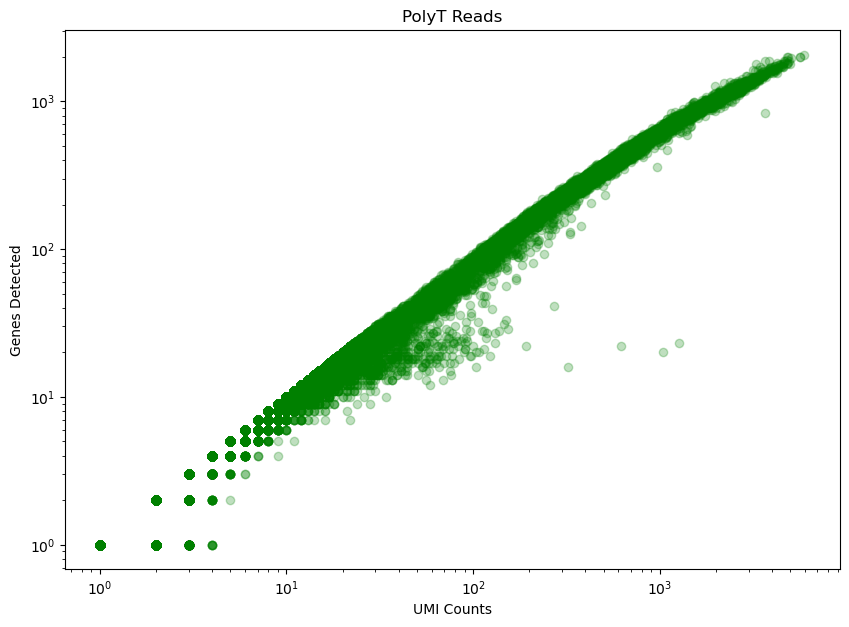

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(raw_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(raw_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("PolyT Reads")

plt.show()

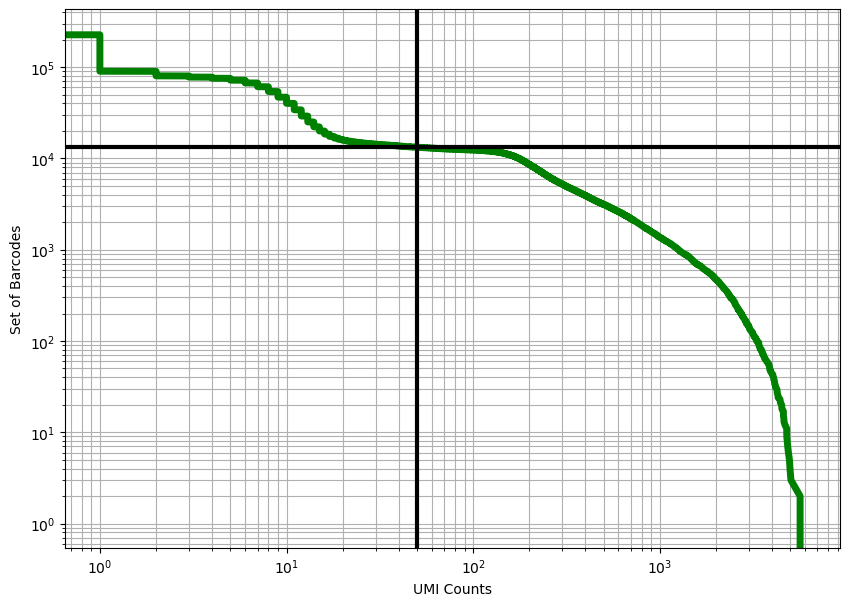

In [5]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 50  #@param {type:"integer"}
knee = np.sort((np.array(raw_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [6]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

13,240 cells passed the 50 UMI threshold


In [7]:
mg = mygene.MyGeneInfo()

# Query Ensembl for gene biotypes
gene_info = mg.querymany(gene_names, scopes='symbol', fields='type_of_gene', species='mouse')
gene_df = pd.DataFrame(gene_info)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


KeyboardInterrupt: 

In [ ]:
# Identify ncRNA genes
raw_data.var["is_nc"] = np.full(len(raw_data.var_names), False)
nc_genes = gene_df[gene_df['type_of_gene'] == 'ncRNA']["query"].tolist()
raw_data.var.loc[nc_genes, ["is_nc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
raw_data.var["is_mito"] = raw_data.var_names.str.startswith("Mt")
# ribosomal genes
raw_data.var["is_ribo"] = raw_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = raw_data[:, raw_data.var['is_mito']].X.sum(axis=1)
ribo_counts = raw_data[:, raw_data.var['is_ribo']].X.sum(axis=1)
nc_counts = raw_data[:, raw_data.var['is_nc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = raw_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
raw_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
raw_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
raw_data.obs['percent_nc'] = np.array(nc_counts / total_counts * 100).flatten()

raw_data.obs['n_counts'] = raw_data.X.sum(axis=1).A1

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_27884/979944673.py:19: RuntimeWarning: invalid value encountered in divide
  raw_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_27884/979944673.py:20: RuntimeWarning: invalid value encountered in divide
  raw_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_27884/979944673.py:21: RuntimeWarning: invalid value encountered in divide
  raw_data.obs['percent_nc'] = np.array(nc_counts / total_counts * 100).flatten()


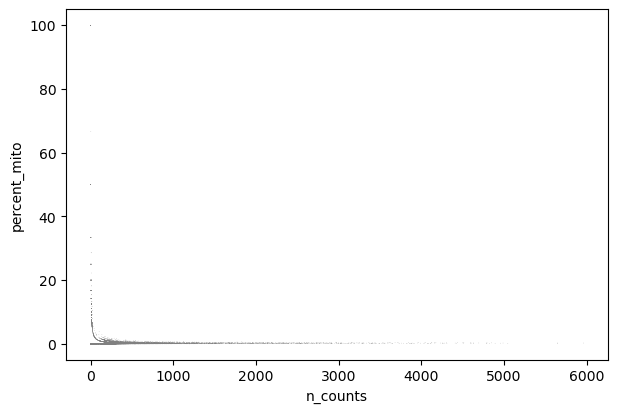

In [ ]:
sc.pl.scatter(raw_data, x='n_counts', y='percent_mito')

In [ ]:
sc.pp.filter_genes(raw_data, min_cells=3)

/opt/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


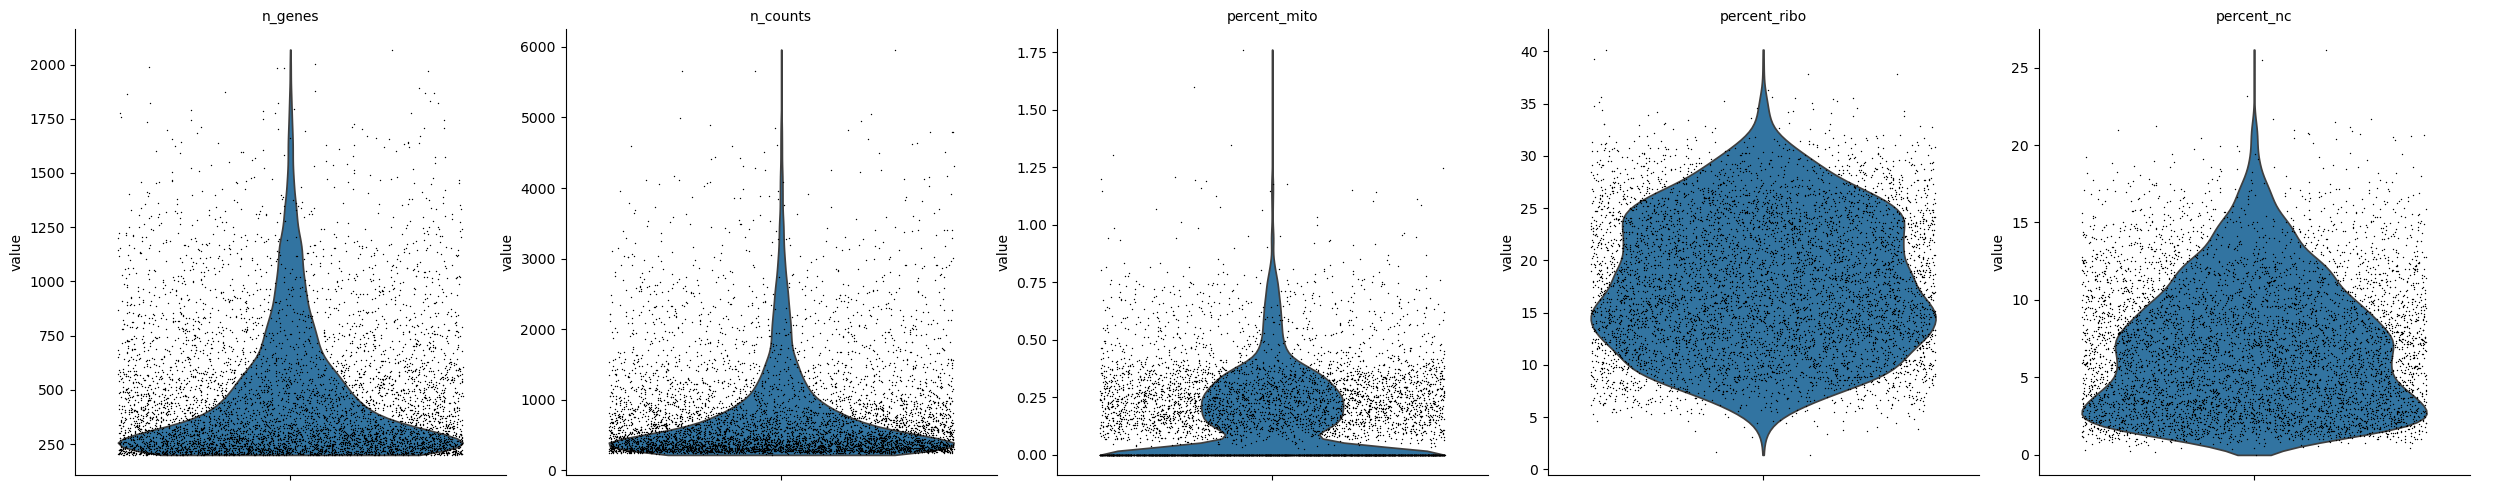

In [ ]:
sc.pl.violin(raw_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_nc'], jitter=0.4, multi_panel=True)


In [ ]:
raw_data.write('processed_10x.h5ad', compression="gzip")

In [ ]:
print(raw_data.obs['n_counts'].tolist())

[265.0, 318.0, 1218.0, 526.0, 2685.0, 941.0, 757.0, 302.0, 892.0, 519.0, 298.0, 261.0, 941.0, 2543.0, 1064.0, 876.0, 1250.0, 989.0, 1700.0, 252.0, 723.0, 270.0, 524.0, 364.0, 842.0, 263.0, 884.0, 1550.0, 372.0, 302.0, 252.0, 2334.0, 1469.0, 483.0, 1048.0, 251.0, 444.0, 836.0, 320.0, 570.0, 1009.0, 359.0, 726.0, 392.0, 277.0, 573.0, 416.0, 2437.0, 1854.0, 323.0, 454.0, 309.0, 497.0, 528.0, 1077.0, 759.0, 570.0, 515.0, 323.0, 502.0, 945.0, 500.0, 565.0, 1039.0, 1258.0, 801.0, 443.0, 377.0, 360.0, 2382.0, 267.0, 477.0, 300.0, 410.0, 772.0, 668.0, 2392.0, 362.0, 495.0, 262.0, 745.0, 373.0, 1075.0, 2340.0, 773.0, 305.0, 275.0, 505.0, 483.0, 805.0, 1197.0, 409.0, 312.0, 598.0, 308.0, 455.0, 267.0, 1286.0, 1255.0, 863.0, 899.0, 589.0, 746.0, 2415.0, 289.0, 258.0, 717.0, 269.0, 286.0, 854.0, 1669.0, 1042.0, 386.0, 273.0, 293.0, 2335.0, 2297.0, 726.0, 937.0, 247.0, 276.0, 322.0, 489.0, 454.0, 889.0, 543.0, 353.0, 290.0, 1733.0, 298.0, 981.0, 281.0, 1777.0, 409.0, 291.0, 382.0, 1137.0, 549.0, 11

# 10x Gene Counts

In [ ]:
genes = raw_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(raw_data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()))

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_18056/2484750936.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(gene_dist, vert = False, labels = top_genes)


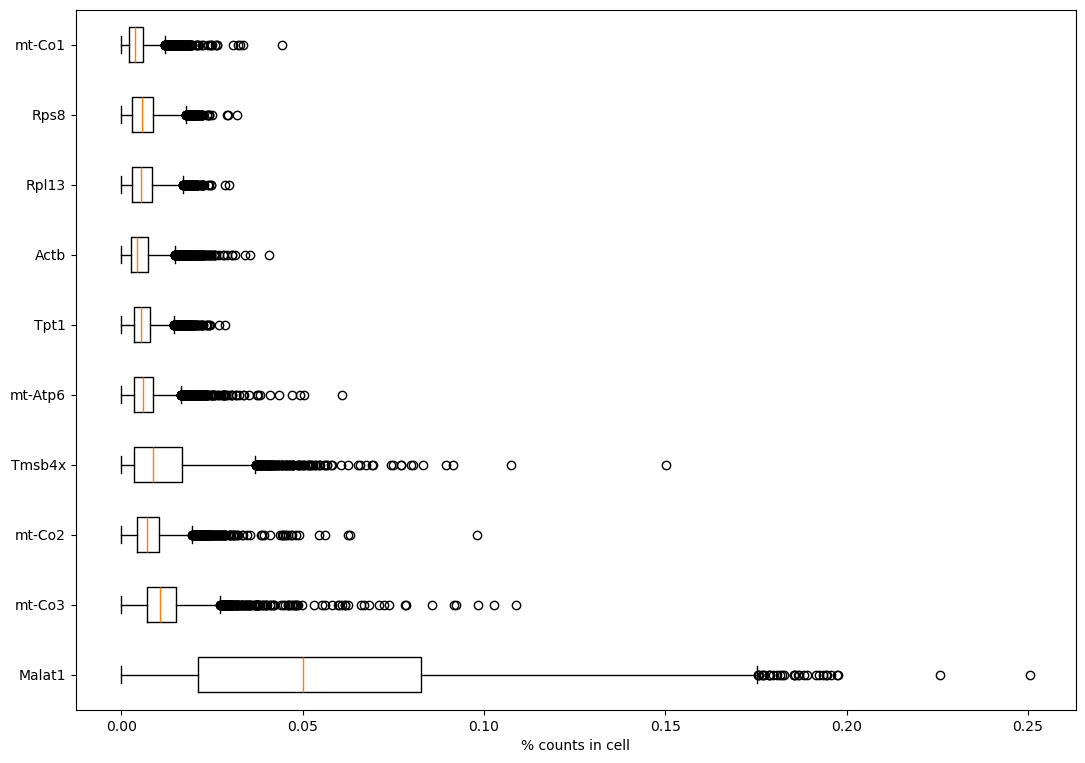

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(gene_dist, vert = False, labels = top_genes)
ax.set_xlabel("% counts in cell")
plt.show()